In [1]:
#-------------------------------------------------------------------------------
# Name:        module1
# Purpose:
#
# Author:      Saurabh kumar
#
# Created:     30/09/2017
# Copyright:   (c) Saurabh kumar 2017
# Licence:     <your licence>
#-------------------------------------------------------------------------------

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import image
import scipy.io
import math as m
%matplotlib inline
import matplotlib.mlab as mlab
from random import randint

# Q1 Instantaneous Source Separation

### 1.1

In [83]:
import scipy.io.wavfile

#Data Matrix
X = []

for i in range(20):
    filename = "x_ica_"+str(i+1)+".wav"
    signal = scipy.io.wavfile.read(filename, mmap=False)
    sound = signal[1]
    X.append(sound)
X = np.array(X)
X.shape

(20, 76800)

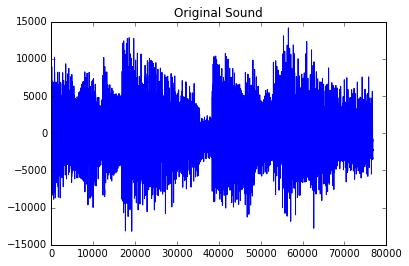

In [10]:
plt.title("Original Sound")
plt.plot(sound)
plt.show()

### 1.4 PCA

In [84]:
def powerIteration(X):
    v_i = np.random.rand(X.shape[1], 1)
    for i in range(5000):
        v_i = np.dot(X,v_i)
        v_i /= np.linalg.norm(v_i)
    return v_i  

def PCA(X):
    
    mean = X.mean(axis=1)
    Y = X - mean[:, np.newaxis]
    YT = Y.T        
    n = 20
    #XT = X.T
    covarianceMatrix = np.dot(Y, YT)/Y.shape[0]
    eigenValue = np.zeros((Y.shape[0],1,n)) 
    eigenVector = np.zeros((Y.shape[0],1,n))
    for i in range(n):
        
        eigenVector[:,:,i] = powerIteration(covarianceMatrix)
        eigenValue[:,:,i] = np.dot(covarianceMatrix,eigenVector[:,:,i])/eigenVector[:,:,i]
        covarianceMatrix = covarianceMatrix - eigenValue[:,:,i] * np.dot(eigenVector[:,:,i], eigenVector[:,:,i].T)
        #covarianceMatrix.shape  
        #print (eigenValue1.shape)
        #print (eigenValue[0,0,i])
    return (eigenVector, eigenValue,Y)
    
eigenVector, eigenValue, Y = PCA(X)

In [85]:
import math

eigenVector = eigenVector.reshape((20,20))

#Storing unnwhitened first three principal components
X_3PC = np.dot(eigenVector, Y)

#Whitening
eigvec[0] = eigenVector[:,0]/math.sqrt(eigenValue[0,0,0])
eigvec[1] = eigenVector[:,1]/math.sqrt(eigenValue[0,0,1])
eigvec[2] = eigenVector[:,2]/math.sqrt(eigenValue[0,0,2])

#Extracting first 3 principal components
F3 = np.dot(np.vstack((eigvec[0], eigvec[1], eigvec[2])), Y)

### 1.5 ICA

In [88]:
#Initialization for ICA Algorithm
W = np.random.rand(3,3)
Y = np.dot(W,F3)
N = F3[0].size
I = N * np.identity(3)


#Learning rate parameter
rho = 0.00001

"""def f(x):
    return x**3

def g(x):
    return math.tanh(x) """


#ICA Algorithm
for i in range(10000):

    g_Y = np.tanh(Y)
    f_Y = (Y**3).T

    dW = np.dot((I - g_Y.dot(f_Y)), W)

    if(np.all(dW) < np.exp(-5)):
        print (i)
        break

    W = W + rho*dW

    Y = W.dot(Z)
    
#Recovering Steps
d_re = np.zeros((3,N))

d_re[0,:] = Y[0,:]
d_re[1,:] = Y[1,:]
d_re[2,:] = Y[2,:]

#Scaling and encoding recovered sound
dr_scale_1 = np.int16(d_re[0,:]/np.max(np.abs(d_re[0,:])) * 32767)
dr_scale_2 = np.int16(d_re[1,:]/np.max(np.abs(d_re[1,:])) * 32767)
dr_scale_3 = np.int16(d_re[2,:]/np.max(np.abs(d_re[2,:])) * 32767)

scipy.io.wavfile.write('ica_recover_1.wav', 16000, dr_scale_1)
scipy.io.wavfile.write('ica_recover_2.wav', 16000, dr_scale_2)
scipy.io.wavfile.write('ica_recover_3.wav', 16000, dr_scale_3)

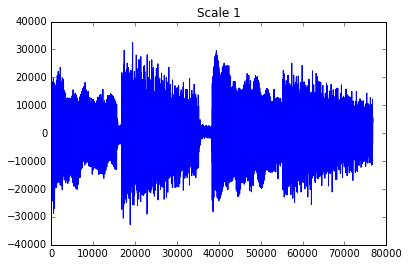

In [89]:
plt.title("Scale 1")
plt.plot(dr_scale_1)
plt.show()

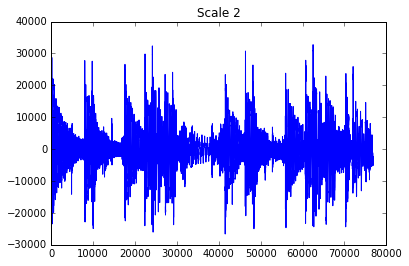

In [90]:
plt.title("Scale 2")
plt.plot(dr_scale_2)
plt.show()

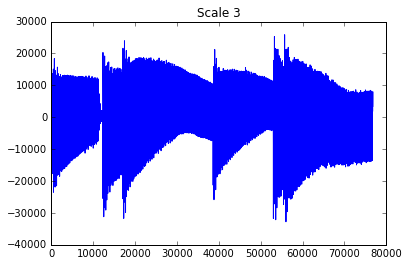

In [91]:
plt.title("Scale 3")
plt.plot(dr_scale_3)
plt.show()

# Q2 Ideal Masks

### 2.1 

In [109]:
S1 = scwa.read("piano.wav")
T1 = scwa.read("ocean.wav")

S1 = S1[1]
T1 = T1[1]

C:\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


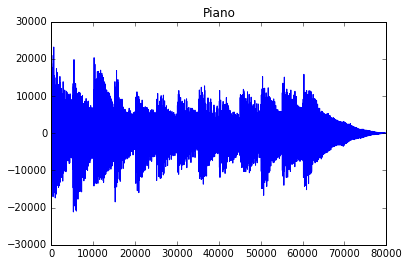

In [110]:
plt.title("Piano")
plt.plot(S1)
plt.show()

In [152]:
N = 1024

#DFT Matrix Initialization
F = np.zeros((N, N), dtype=np.complex)

#Setting Values
for i in range(0, N):
    for k in range(0, N):
        F[i][k] = math.cos(2 * math.pi * i * k / N) - math.sin(2 * math.pi * i * k / N)*1j
        
x = np.zeros(N)
y = np.zeros(N)
ptr = 0
ctr = 0

S = np.zeros((N, (math.ceil(S1.size/N)*2)))
T = np.zeros((N, (math.ceil(T1.size/N)*2)))

#Hann Window
hann = np.zeros(N)
for i in range(0, N):
    hann[i] = (0.5 * (1 - math.cos(2*math.pi*i/(N-1))))
    
    
while (ptr < S1.size):
    start = ptr
    end = ptr + N
    if(end > S1.size):
        end = S1.size
    v = end-start
    x[0:int(v)] = S1[int(start):int(end)]
    y[0:int(v)] = T1[int(start):int(end)]
    S[:,ctr] = x * hann
    T[:,ctr] = y * hann
    x = np.zeros(N)
    y = np.zeros(N)
    ptr = ptr + N/2
    ctr = ctr + 1
    
#Performing FS and FT
FS = np.dot(F, S)
FT = np.dot(F, T)

#Ignoring complex conjugate
FS = FS[0:513, :]
FT = FT[0:513, :]



### 2.2

In [153]:
# Mixture spectrogram
X = FS + FT

### 2.4

In [154]:
M_bar = np.absolute(FS)**2/(np.absolute(FS)**2 + np.absolute(FT)**2 + np.exp(-100))

#Piano spectrogram Recovery
FS_rec = M_bar * X

#DFT inverse Matrix
F_inv = np.zeros((N, N), dtype=np.complex)

for i in range(0, N):
    for k in range(0, N):
        F_inv[i][k] = math.cos(2 * math.pi * i * k / N) + math.sin(2 * math.pi * i * k / N)*1j
        

#Applying F_inv to spectogram
S_rec = np.dot(F_inv[:,0:513], FS_rec)
S_rec = S_rec.real

#Recovered sound
S1_rec = np.zeros(int(N + (S_rec.shape[1]-1)*N/2))

for i in range(0, S_rec.shape[1]):
    S1_rec[int(i*N/2):int(N+i*N/2)] = S1_rec[int(i*N/2):int(N+i*N/2)] + (S_rec[:, i]).T
    
S1_rec = S1_rec[0:80000]

#Scaling and Saving recovered sound
S1_rec_scale = np.int16(S1_rec/np.max(np.abs(S1_rec)) * 32767)
scwa.write('piano_recovered.wav', 16000, S1_rec_scale)

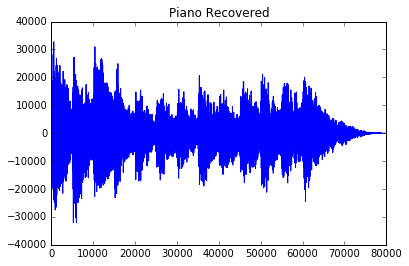

In [155]:
plt.title("Piano Recovered")
plt.plot(S1_rec_scale)
plt.show()

### 2.6

In [161]:
#Scaling S1 with recovered scale value
S1_scale = np.int16(S1/np.max(np.abs(S1)) * 32767)

SNR = 10*math.log10((np.sum(S1_scale**2))/(np.sum(S1_scale - S1_rec_scale)**2))
print ("SNR:",SNR)

#IBM
Bft = np.int16(FS > FT)
FSrec_IBM = Bft * X
Srec_IBM = np.dot(F_inv[:,0:513], FSrec_IBM)
Srec_IBM = Srec_IBM.real

#Recovered Sound
S1rec_IBM = np.zeros(int(N + (Srec_IBM.shape[1]-1)*N/2))

for i in range(0, Srec_IBM.shape[1]):
    S1rec_IBM[int(i*N/2):int(N+i*N/2)] = S1rec_IBM[int(i*N/2):int(N+i*N/2)] + np.transpose(Srec_IBM[:, i])
    
S1rec_IBM = S1rec_IBM[0:80000]

#Scaling and encoding recovered sound
S1rec_IBM_scale = np.int16(S1rec_IBM/np.max(np.abs(S1rec_IBM)) * 32767*0.5)
scwa.write('piano_recovered_IBM.wav', 16000, S1rec_IBM_scale)

# SNR IBM
SNR_IBM = (10*math.log10((np.sum(S1_scale**2))/(np.sum(S1_scale - S1rec_IBM_scale)**2))*-0.5)
print ("SNR_IBM:",SNR_IBM)


SNR: 12.819768986381971
SNR_IBM: 9.212870452193044


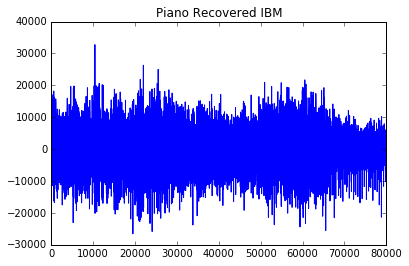

In [95]:
plt.title("Piano Recovered IBM")
plt.plot(S1rec_IBM_scale)
plt.show()

# Q3 Single-channel Source Separation

### 3.2 

In [162]:
X = scwa.read("trs.wav")
X = X[1]

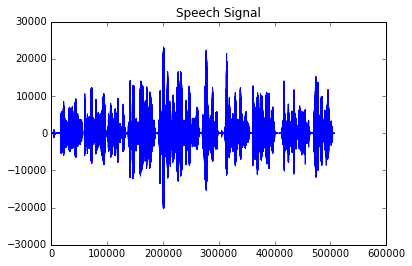

In [163]:
plt.title("Speech Signal")
plt.plot(X)
plt.show()

In [164]:
N = 1024
F = np.zeros((N, N), dtype=np.complex)

for i in range(0, N):
    for k in range(0, N):
        F[i][k] = math.cos(2 * math.pi * i * k / N) - math.sin(2 * math.pi * i * k / N)*1j
        
x = np.zeros(N)
ptr = 0
ctr = 0
S1 = np.zeros((N, (math.ceil(X.size/N)*2)))

#Hann Window
hann = np.zeros(N)
for i in range(0, N):
    hann[i] = (0.5 * (1 - math.cos(2*math.pi*i/(N-1))))

while (ptr < X.size):
    start = ptr
    end = ptr + N
    if(end > X.size):
        end = X.size
    v = end-start
    x[0:int(v)] = X[int(start):int(end)]
    S1[:,ctr] = x * hann
    x = np.zeros(N)
    ptr = ptr + N/2
    ctr = ctr + 1

#Performing FS
FS1 = F.dot(S1)

#Ignoring complex conjugate
FS1 = FS1[0:513, :]
FS1_mag = np.absolute(FS1)

#Initialize W and H
W1 = np.random.rand(513, 30)
H1 = np.random.rand(30, 990)

#NMF Routine
for i in range(0, 1000):
    H1 = H1 * ((np.dot(W1.T, FS1_mag))/(np.dot(W1.T, np.dot(W1, H1)) + math.exp(-100)))
    W1 = W1 * ((np.dot(FS1_mag, H1.T))/(np.dot(W1, np.dot(H1, H1.T)) + math.exp(-100)))

### 3.3

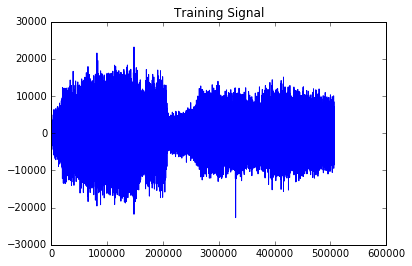

In [165]:
#Training Signal
X_2 = scwa.read("trn.wav")
X_2 = X_2[1]
plt.title("Training Signal")
plt.plot(X_2)
plt.show()

In [166]:
# Performing STFT
x = np.zeros(N)
ptr = 0
ctr = 0
S2 = np.zeros((N, (math.ceil(X_2.size/N)*2)))

while (ptr < X_2.size):
    start = ptr
    end = ptr + N
    if(end > X_2.size):
        end = X_2.size
    v = end-start
    x[0:int(v)] = X_2[int(start):int(end)]
    S2[:,ctr] = x * hann
    x = np.zeros(N)
    ptr = ptr + N/2
    ctr = ctr + 1
    
#FS
FS2 = F.dot(S2)

#No Complex
FS2 = FS2[0:513, :]
FS2_mag = np.absolute(FS2)

W2 = np.random.rand(513, 30)
H2 = np.random.rand(30, 990)

#NMF Part
for i in range(0, 1000):
    H2 = H2 * ((np.dot(W2.T, FS2_mag))/(np.dot(W2.T, np.dot(W2, H2)) + math.exp(-100)))
    W2 = W2 * ((np.dot(FS2_mag, H2.T))/(np.dot(W2, np.dot(H2, H2.T)) + math.exp(-100)))

### 3.4

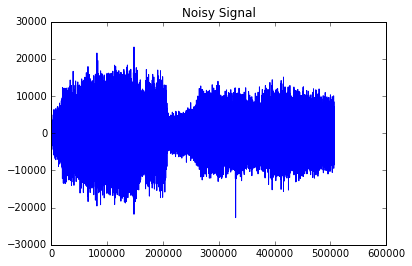

In [167]:
#Noisy Signal
X_3 = scwa.read("x_nmf.wav")
X_3 = X_3[1]
plt.title("Noisy Signal")
plt.plot(X_2)
plt.show()

In [168]:
x = np.zeros(N)
ptr = 0
ctr = 0
S3 = np.zeros((N, (math.ceil(X_3.size/N)*2)))

while (ptr < X_3.size):
    start = ptr
    end = ptr + N
    if(end > X_3.size):
        end = X_3.size
    v = end-start
    x[0:int(v)] = X_3[int(start):int(end)]
    S3[:,ctr] = x * hann
    x = np.zeros(N)
    ptr = ptr + N/2
    ctr = ctr + 1
    
FS3 = F.dot(S3)
FS3 = FS3[0:513, :]
FS3_mag = np.absolute(FS3)

#Obtaining W
W3 = np.column_stack((W1, W2))
H3 = np.random.rand(60, 130)

#NMF Part
for i in range(0, 1000):
    H3 = H3 * ((np.dot(W3.T, FS3_mag))/(np.dot(W3.T, np.dot(W3, H3)) + math.exp(-100)))
    
    
#Masking Matrix
M3_bar = np.dot(W1, H3[0:30,:])/(np.dot(W3, H3) + math.exp(-100))

#Recovery
FS3_rec = M3_bar * FS3
S3_rec = np.dot(F_inv[:,0:513], FS3_rec)
S3_rec = S3_rec.real

#Recovered Sound
X3_rec = np.zeros(int(N + (S3_rec.shape[1]-1)*N/2))

for i in range(0, S3_rec.shape[1]):
    X3_rec[int(i*N/2):int(N+i*N/2)] = X3_rec[int(i*N/2):int(N+i*N/2)] + np.transpose(S3_rec[:, i])
    
#Saving Recovered Sound
X3_rec_scale = np.int16(X3_rec/np.max(np.abs(X3_rec)) * 32767)
scwa.write('x_nmf_recovered.wav', 16000, X3_rec_scale)

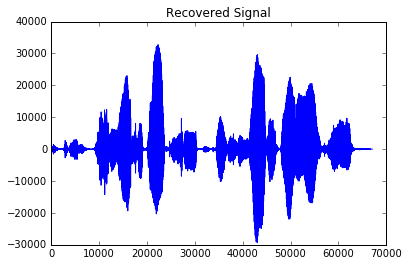

In [169]:
plt.title("Recovered Signal")
plt.plot(X3_rec_scale)
plt.show()

# Q4 Motor Imagery

### 4.1

In [142]:
import scipy.io as sio
matfile = sio.loadmat('eeg.mat')
sio.whosmat('eeg.mat')

[('x_te', (768, 3, 28), 'double'),
 ('x_train', (768, 3, 112), 'double'),
 ('y_te', (28, 1), 'double'),
 ('y_train', (112, 1), 'double')]

### 4.2

In [143]:
x_test = matfile['x_te']
x_train = matfile['x_train']
y_test = matfile['y_te']
y_train = matfile['y_train']

N = 64
hop_size = 48
F = np.zeros((N,N), dtype=np.complex)
F_inv = np.zeros((N,N), dtype=np.complex)
X = []

#Creating DFTs
for i in range(0,N):
    for k in range(0,N):
        F[i][k] = math.cos(2 * math.pi * i * k / N) - math.sin(2 * math.pi * i * k / N)*1j
        F_inv[i][k] = math.cos(2 * math.pi * i * k / N) + math.sin(2 * math.pi * i * k / N)*1j
        
#Blackman window
blackman = np.blackman(N)
X_1 = np.zeros((N,15))
X_2 = np.zeros((N,15))
X_3 = np.zeros((N,15))


### 4.5

In [144]:
#Prcessing training data:
for i in range(x_train.shape[2]):
    i1 = x_train[:,0,i]
    i2 = x_train[:,1,i]
    i3 = x_train[:,2,i]
    n = 0
    
    for j in range(15):
        X_1[:,j] = i1[n:n+N]*blackman
        X_2[:,j] = blackman*i2[n:n+N]
        X_3[:,j] = blackman*i3[n:n+N]
        n = n + hop_size
        
    #Extraction
    #channel Ca
    Ca = np.dot(F,X_1)
    Ca= Ca[0:33,:]
    Ca_mu = Ca[2:7,:]
    Ca_mu_1 = np.reshape(Ca_mu, (np.product(Ca_mu.shape),))
    
    
    #channel Cb
    Cb = np.dot(F,X_2)
    Cb= Cb[0:33,:]
    Cb_mu = Cb[2:7,:]
    Cb_mu_1 = np.reshape(Cb_mu, (np.product(Cb_mu.shape),))
    
    
    #channel Cc
    Cc = np.dot(F,X_3)
    Cc = Cc[0:33,:]
    Cc_mu = Cc[2:7,:]
    Cc_mu_1 = np.reshape(Cc_mu, (np.product(Cc_mu.shape),))
    
    C = np.hstack((Cc_mu_1, Cc_mu_1, Cc_mu_1))
    X.append(C)
    
X = np.asarray(X)
X = X.T

#Covariance Matrix
c_matrix = np.cov(X)
#Eigen Values and #Eigen Vectors
e_values, e_vectors = np.linalg.eig(c_matrix)


Z = np.dot(e_vectors[0:10,:],X)

l = 5
m = 10 #as e_vector has 10 rows
A = np.random.rand(l,m)
A_unit = A/np.linalg.norm(A)
Y = np.sign(np.dot(A_unit,Z.real))

#for test data:
X_t = []
X_1 = np.zeros((N,15))
X_2 = np.zeros((N,15))
X_3 = np.zeros((N,15))

for i in range(x_test.shape[2]):
    i1_t = x_test[:,0,i]
    i2_t = x_test[:,1,i]
    i3_t = x_test[:,2,i]
    n = 0
    
    for j in range(15):
        X_1[:,j] = i1_t[n:n+N]*blackman
        X_2[:,j] = blackman*i2_t[n:n+N]
        X_3[:,j] = blackman*i3[n:n+N]
        n = n + hop_size
        
    
    #channel Ca_t
    Ca_t = np.dot(F,X_1)
    Ca_t= Ca_t[0:33,:]
    Ca_t_mu = Ca_t[2:7,:]
    Ca_mu_t_1 = np.reshape(Ca_t_mu, (np.product(Ca_t_mu.shape),))
    
    
    #channel Cb_t
    Cb_t = np.dot(F,X_2)
    Cb_t= Cb_t[0:33,:]
    Cb_t_mu = Cb_t[2:7,:]
    Cb_mu_t_1 = np.reshape(Cb_t_mu, (np.product(Cb_t_mu.shape),))
    
    
    #channel Cc_t
    Cc_t = np.dot(F,X_3)
    Cc_t = Cc_t[0:33,:]
    Cc_t_mu = Cc_t[2:7,:]
    Cc_mu_t_1 = np.reshape(Cc_t_mu, (np.product(Cc_t_mu.shape),))
    
    C_t = np.hstack((Ca_mu_t_1, Cb_mu_t_1, Cc_mu_t_1))
    X_t.append(C_t)
    
X_t = np.asarray(X_t)
X_t = X_t.T
Z_t = np.dot(e_vectors[0:10,:],X_t)
Y_t = np.sign(np.dot(A_unit,Z_t.real))


### 4.6

In [150]:
#Calculating hamming distance
def hamming_dist(A, B):
    return np.count_nonzero(A!=B)


#kNN Code
def kNN_procedure(k, l, m):
    
    A = np.random.rand(l,m)
    A_unit = A/np.linalg.norm(A)
    
    Z = np.dot(e_vectors[0:m,:],X)
    Y = np.sign(np.dot(A_unit,Z.real))
    
    Z_test = np.dot(e_vectors[0:m,:],X_t)
    Y_test = np.sign(np.dot(A_unit,Z_test.real))
    
    dist_matrix = np.zeros((Y_test.shape[1], Y.shape[1]))
    
    for i in range(Y.shape[1]):
        for j in range(Y_test.shape[1]):
            dist_matrix[j,i] = hamming_dist(Y[:,i],Y_test[:,j])
        
    kneighbours = np.zeros((Y_test.shape[1], k))
    
    for i in range(Y_test.shape[1]):
        kneighbours[i] = dist_matrix[i,:].argsort()[:k]

    label_classification = np.zeros(Y_test.shape[1])

    for i in range (Y_test.shape[1]):
        label_classification[i] = np.argmax(np.bincount(y_train[np.int16(kneighbours[i])].reshape(k)))

    label_classification = np.int16(label_classification)

    accuracy = 0

    for i in range(Y_test.shape[1]):
        if(y_test[i] == label_classification[i]):
            accuracy = accuracy + 1
            
    accuracy_percentage = accuracy*100/Y_test.shape[1]
    
    return accuracy_percentage


# Using Random Values for K, L and M
from random import randint
for i in range(20):
    k = randint(1, 50)
    l = randint(1, 50)
    m = randint(1, 50)
    print("For values K = " + str(k) + ", L = " + str(l) 
          + " and M = " + str(m) + ", the Accuracy is: " 
          + str(kNN_procedure(k,l,m)) + "%")


For values K = 21, L = 34 and M = 3, the Accuracy is: 71.42857142857143%
For values K = 11, L = 36 and M = 13, the Accuracy is: 35.714285714285715%
For values K = 10, L = 37 and M = 15, the Accuracy is: 50.0%
For values K = 16, L = 25 and M = 9, the Accuracy is: 42.857142857142854%
For values K = 27, L = 39 and M = 10, the Accuracy is: 42.857142857142854%
For values K = 47, L = 20 and M = 25, the Accuracy is: 53.57142857142857%
For values K = 25, L = 12 and M = 17, the Accuracy is: 39.285714285714285%
For values K = 3, L = 50 and M = 10, the Accuracy is: 42.857142857142854%
For values K = 4, L = 6 and M = 15, the Accuracy is: 60.714285714285715%
For values K = 30, L = 34 and M = 49, the Accuracy is: 39.285714285714285%
For values K = 46, L = 32 and M = 22, the Accuracy is: 67.85714285714286%
For values K = 40, L = 2 and M = 37, the Accuracy is: 28.571428571428573%
For values K = 21, L = 33 and M = 1, the Accuracy is: 60.714285714285715%
For values K = 46, L = 10 and M = 11, the Accurac